### Todo

Add and tune a simple model in order to see if our more complex models are worth it. Reference model # DONE

Tune our complex models

Try PCA/Auto encoder approaches

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [20]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
#os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

from matplotlib import pyplot
import pandas as pd 
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics as met
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

#Here we set a seed so that our random search produce the same result 
np.random.seed(31415)

# Here we create a scoring dictionary which defines the metrics we report on in cross validation
scoring = {
    'accuracy': met.make_scorer(met.accuracy_score),
    'precision': met.make_scorer(met.precision_score),
    'sensitivity': met.make_scorer(met.recall_score),
    'specificity': met.make_scorer(met.recall_score,pos_label = 0),
    'f1': met.make_scorer(met.f1_score),
    'roc_auc': met.make_scorer(met.roc_auc_score)
}

refit = {'sensitivity': met.make_scorer(met.recall_score)}


#### In this cell we import our training data, convert HALL into HALL_EVER and select only BL observations.

In [21]:
train = pd.read_csv('train.csv')
temptrain = pd.DataFrame(train.PATNO.unique(), columns = ["PATNO"])

HALL_EVER = []
for id in train.PATNO.unique():
    if train.loc[(train.PATNO == id) & (train.HALL == 1), "HALL"].empty:
        HALL_EVER.append(0)
    else:
        HALL_EVER.append(1)

temptrain["HALL_EVER"] = HALL_EVER
train.drop("HALL", axis = 1, inplace = True)
train = train.merge(temptrain, how = "inner", on = "PATNO")

#Selecting only Baseline observations
train = train.loc[train.EVENT_ID == "BL", :]

#We can then safely drop EVENT_ID and PATNO
train.drop(["EVENT_ID", "PATNO"], axis = 1, inplace = True)

# We form Y
Y = train.pop("HALL_EVER")

print(train.shape)

(335, 21)


In [22]:
import imblearn as imbl

def over_sampling(model, X):
    
    column_types = pd.read_csv("Column_Data_Types_Final.csv")
    categorical_columns = column_types.loc[(column_types.DATA_TYPE == "Categorical") | (column_types.DATA_TYPE == "Ordinal") , "COLUMN_NAME"].values
    categorical_columns = list(set(categorical_columns).intersection(set(X.columns)))
    categorical_columns = [X.columns.get_loc(c) for c in categorical_columns if c in X]

    #over = imbl.over_sampling.SMOTENC(categorical_columns, sampling_strategy = 0.8)
    #under = imbl.under_sampling.RandomUnderSampler(sampling_strategy = 1)
    #steps = [('o', over), ('u', under), ('m', model)]
    pipeline = imbl.pipeline.make_pipeline(imbl.over_sampling.SMOTENC(categorical_columns, sampling_strategy = 1),
                                          model)
    
    return pipeline

#### In this cell we define general functions for hyperparameter tuning and cross validation using sklearn functions

In [23]:
'''
metrics from sklearn that we can put into scoring variable:
‘accuracy’
‘balanced_accuracy’
‘average_precision’
‘neg_brier_score’
‘f1’
‘neg_log_loss’
‘precision’ etc.
‘recall’ etc.
‘jaccard’ etc.
‘roc_auc’
'''
def randomized_tuning (X,Y, model, param_dist, k_folds, n_iter, scoring_metrics, scoring_refit, over_sample = False):
    '''
    model should be a XGBClassifier or sklearn classifier 
    param_dist can look like this, remember that it a randomized search through distributions, not a grid search:
    param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
    k_folds = number of folds in CV
    n_iter = number of different random combination of parameters tried. More iterations gives a higher chance of finding the best parameters
    scoring metrics = the metrics the search wil report on a the end, example: ['roc_auc', 'f1']
    scoring_refit = The single metric that will be used to find a "best estimator" at the end,  pick one metric from your scoring metrics list. e.g "f1" or 
    set to False if manually finding best estimator
    '''
    if over_sample == True:
        model= over_sampling(model, X)
    
    clf = RandomizedSearchCV(model, param_distributions = param_dist, cv = k_folds, n_iter = n_iter, scoring = scoring_metrics, refit = scoring_refit, \
                             error_score = 0, verbose = 1, n_jobs = -1, return_train_score = True)
    '''
    If scoring_refit is set you can get the best params on that metric by return.best_params_
    Manual inspection can be done by pd.DataFrame(return.cv_results_)
    '''
    return clf.fit(X,Y)


def CV_report (model, X, Y, k_folds, scoring, over_sample = False):
    
    if over_sample == True:
        model= over_sampling(model, X)
        
    cv_results = cross_validate(model, X, Y, cv= k_folds, scoring= scoring, n_jobs = -1,  verbose = 1, return_train_score = True)
    
    df = pd.DataFrame(columns = ["Metric", "Train mean", "Train SD", "Test mean", "Test SD"])
    rows_list = []
    for x in scoring:
        score_dict = {}
        score_dict["Metric"] = x
        score_dict["Train mean"] = np.mean(cv_results["train_" + x])
        score_dict["Train SD"] = np.std(cv_results["train_" + x])
        score_dict["Test mean"] = np.mean(cv_results["test_" + x])
        score_dict["Test SD"] = np.std(cv_results["test_" + x])  
        rows_list.append(score_dict)
      
    print(df.append(pd.DataFrame(rows_list), sort = False))

#### In this cell we apply logistic regression from sklearn as our simple comparison model 

In [24]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', n_jobs = -1)

CV_report(clf_log, train, Y, 10, scoring)

param_dist = { 'C' : stats.uniform(0.01, 10)
             }

results = randomized_tuning(train,Y,clf_log, param_dist, 10, 10, scoring,'sensitivity')
params = results.best_params_
print(params)
clf_log = LogisticRegression(**params,solver = 'lbfgs', class_weight = 'balanced', n_jobs = -1)
CV_report(clf_log, train, Y, 10, scoring)

new_param_dist = {'logisticregression__' + key: param_dist[key] for key in param_dist}

clf_log = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', n_jobs = -1)
results = randomized_tuning(train,Y,clf_log, new_param_dist, 10, 10, scoring,'sensitivity', over_sample = True)
params = {key[key.find('_') + 2:]: results.best_params_[key] for key in results.best_params_}
print(params)

clf_log = LogisticRegression(**params,solver = 'lbfgs', class_weight = 'balanced', n_jobs = -1)
CV_report(clf_log,train,Y,10,scoring, over_sample = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.705142  0.011592   0.626292  0.071371
1    precision    0.470062  0.014765   0.378463  0.079853
2  sensitivity    0.663023  0.017015   0.526667  0.113768
3  specificity    0.720853  0.015548   0.662667  0.109001
4           f1    0.549955  0.013083   0.433820  0.073843
5      roc_auc    0.691938  0.010667   0.594667  0.058927
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s


{'C': 6.468186059087547}


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.705472  0.012764   0.629323  0.068459
1    precision    0.470720  0.016143   0.379414  0.080665
2  sensitivity    0.667886  0.018721   0.526667  0.113768
3  specificity    0.719485  0.017013   0.667000  0.101603
4           f1    0.552053  0.014613   0.435512  0.077711
5      roc_auc    0.693686  0.011811   0.596833  0.060760
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 6.184447040094182}
        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.685897  0.006618   0.641889  0.055965
1    precision    0.442524  0.007139   0.375408  0.085213
2  sensitivity    0.600693  0.031861   0.493333  0.144973
3  specificity    0.717640  0.017394   0.696333  0.077967
4           f1    0.509254  0.012805   0.422476  0.103948
5      roc_auc    0.659166  0.009318   0.594833  0.069474


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


#### In this cell we apply random forest from XGBOOST

In [25]:
dtrain = xgb.DMatrix(train, label = Y)


#Random Forest
params = {
  'colsample_bynode': 0.8,
    'n_estimators' : 1,
  'learning_rate': 1,
  'max_depth': 5,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.8,
  'scale_pos_weight' : 2.3
}

clf_xgb = XGBClassifier(**params)
CV_report(clf_xgb, train, Y, 10, scoring)

clf_xgb = XGBClassifier(objective = 'binary:logistic', n_estimators = 1, learning_rate = 1, scale_pos_weight = 2.3)
param_dist = { 'colsample_bynode': stats.uniform(0.5, 0.45),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],             
              'subsample': stats.uniform(0.3, 0.6),
              'num_parallel_tree': stats.randint(50,200), 
              'max_delta_step' : stats.uniform(0,15),
             }

results = randomized_tuning(train,Y,clf_xgb, param_dist, 10, 100, scoring,'sensitivity')
params = results.best_params_
print(params)

clf_xgb = XGBClassifier(**params, objective = 'binary:logistic', n_estimators = 1, learning_rate = 1, scale_pos_weight = 2.3)
CV_report(clf_xgb, train, Y, 10, scoring)

clf_xgb = XGBClassifier(objective = 'binary:logistic', n_estimators = 1, learning_rate = 1)

new_param_dist = {'xgbclassifier__' + key: param_dist[key] for key in param_dist}

results = randomized_tuning(train,Y,clf_xgb, new_param_dist, 10, 10, scoring,'sensitivity', over_sample = True)
params = {key[key.find('_') + 2:]: results.best_params_[key] for key in results.best_params_}
print(params)

clf_xgb = XGBClassifier(**params, objective = 'binary:logistic', n_estimators = 1, learning_rate = 1)
CV_report(clf_xgb,train,Y,10,scoring, over_sample = True)

#model_RF = xgb.train(params, dtrain, num_boost_round=1)
#xgb.plot_importance(model_RF)
#pyplot.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.912771  0.009610   0.728253  0.092250
1    precision    0.826257  0.031287   0.534466  0.186285
2  sensitivity    0.861999  0.025774   0.462222  0.140123
3  specificity    0.931712  0.015429   0.827833  0.098164
4           f1    0.843076  0.015945   0.484597  0.142474
5      roc_auc    0.896856  0.011049   0.645028  0.098111
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


{'colsample_bynode': 0.632486424708579, 'max_delta_step': 10.55767648418442, 'max_depth': 3, 'num_parallel_tree': 187, 'subsample': 0.8456906218621558}
        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.818905  0.011412   0.722549  0.116262
1    precision    0.659427  0.027868   0.531125  0.184730
2  sensitivity    0.699458  0.072426   0.517778  0.115491
3  specificity    0.863396  0.030068   0.799500  0.128173
4           f1    0.675788  0.029910   0.517324  0.142171
5      roc_auc    0.781427  0.024704   0.658639  0.110792
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'colsample_bynode': 0.824430271088985, 'max_delta_step': 1.3553103401676263, 'max_depth': 3, 'num_parallel_tree': 192, 'subsample': 0.7314055424466176}
        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.760525  0.023127   0.644652  0.080370
1    precision    0.557715  0.061543   0.366121  0.150491
2  sensitivity    0.697215  0.096230   0.513333  0.214867
3  specificity    0.784170  0.060205   0.691500  0.108363
4           f1    0.610631  0.030967   0.422683  0.169547
5      roc_auc    0.740692  0.024662   0.602417  0.102071


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [26]:
results.best_params_

{'xgbclassifier__colsample_bynode': 0.824430271088985,
 'xgbclassifier__max_delta_step': 1.3553103401676263,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__num_parallel_tree': 192,
 'xgbclassifier__subsample': 0.7314055424466176}

#### In this cell we apply boosted treesfrom XGBOOST

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.746285  0.024170   0.686364  0.085996
1    precision    0.535117  0.049054   0.440317  0.129515
2  sensitivity    0.621349  0.089707   0.453333  0.163963
3  specificity    0.792841  0.054798   0.774000  0.099239
4           f1    0.568880  0.037991   0.436547  0.130453
5      roc_auc    0.707095  0.026910   0.613667  0.096621
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.708796  0.030802   0.656774  0.099681
1    precision    0.481807  0.042913   0.420913  0.102151
2  sensitivity    0.646989  0.102587   0.564444  0.165462
3  specificity    0.731733  0.075579   0.693167  0.141322
4           f1    0.545011  0.025736   0.469688  0.112784
5      roc_auc    0.689361  0.020850   0.628806  0.092131
[16:31:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




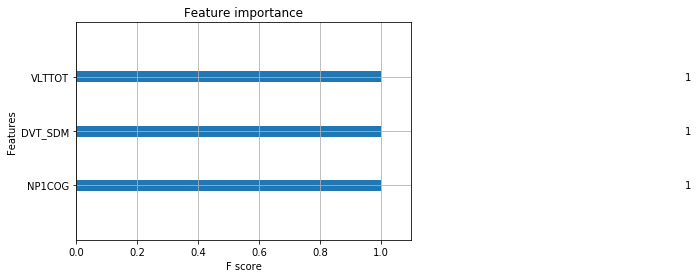

In [27]:
dtrain = xgb.DMatrix(train, label = Y)

#Boosted trees
params = {
    'n_estimators' : 2,
  'learning_rate': 1,
  'max_depth': 2,
  'objective': 'binary:logistic',
    'scale_pos_weight':  2.3
}

clf_xgb = XGBClassifier(**params)
CV_report(clf_xgb, train, Y, 10, scoring)

clf_xgb = XGBClassifier(objective = 'binary:logistic', scale_pos_weight = 2.3)
param_dist = {'n_estimators': stats.randint(1, 10),
              'learning_rate': stats.uniform(0.01, 0.99),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [1,2,3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3],
              'max_delta_step' : stats.uniform(0,15),
             }

results = randomized_tuning(train,Y,clf_xgb, param_dist, 10, 100, scoring,'sensitivity')
params = results.best_params_

clf_xgb = XGBClassifier(**params, objective = 'binary:logistic', scale_pos_weight = 2.3)
CV_report(clf_xgb, train, Y, 10, scoring)


model_RF = xgb.train(params, dtrain, num_boost_round=1)
xgb.plot_importance(model_RF)
pyplot.show()

In [28]:
results.best_params_

{'colsample_bytree': 0.8322607563499156,
 'learning_rate': 0.05249592491837748,
 'max_delta_step': 0.20061879748741185,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 9,
 'subsample': 0.9953045836640129,
 'validate_parameters': 1}

#### In this cell we apply SVM from scikit-learn

In [29]:
clf1 = svm.SVC(random_state=0, gamma='auto', kernel='rbf')
CV_report(clf1, train, Y, 10, scoring)

        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.775463  0.008479   0.734670  0.030831
1    precision    1.000000  0.000000   0.450000  0.471699
2  sensitivity    0.173366  0.032089   0.066667  0.073703
3  specificity    1.000000  0.000000   0.983833  0.026688
4           f1    0.294238  0.046255   0.114545  0.124130
5      roc_auc    0.586683  0.016045   0.525250  0.042936


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [30]:
clf2 = svm.SVC(random_state=0, gamma='auto', kernel='linear')
CV_report(clf2, train, Y, 10, scoring)

        Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.783415  0.007742   0.767380  0.055660
1    precision    0.775743  0.029729   0.665000  0.393732
2  sensitivity    0.286811  0.043866   0.252222  0.171273
3  specificity    0.968578  0.008251   0.959000  0.055172
4           f1    0.416332  0.047814   0.345730  0.215931
5      roc_auc    0.627695  0.018949   0.605611  0.086797


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
